Fixed radius neighbour selection are previously benchmarked with Periodic KDTree, Biopython KDtree, Scipy KDtree, Neighbour search implemented in FATSLiM ([here](https://github.com/seb-buch/Benchmarks_Distance/blob/6166f4fe668ac0ad32a16fb48b6a65e70968cfd2/Notebooks/CythonNS.ipynb)). Another possible data structure for possible speedup in distance evaluations is Octree. PCL library ([here](https://github.com/strawlab/python-pcl)) has been used to find the neighbours within a fixed radius of a query point. The timings for single queries are checked against other structures. Since, all but Periodic KDTree and Neighbour search are can't handle periodicity, a query point is chosen deep in side the box.

The goal of the notebook is to check the scaling of each method against number of particles and cutoff radius. 

While another implementation of Octree (index based) is claimed to be more fast than its counterparts, we have used a general implementation of Octree based on Barnes Hut algorithm.
The adhoc timings corresponding to c++ octree implementation (more faster) for fixed neighbour search (available [here](https://github.com/jbehley/octree)) is also noted in the notebook. However, it would not be useful for anyone else to compare, as it is system specific.

In [2]:
import numpy as np
from collections import defaultdict
import itertools

In [3]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

def _check_box(box):
        return box[:3] if box.shape == (6,) else box    

In [4]:
BOX = np.array([100.,100.,100.,90,90,90],dtype=np.float32)
CUTOFF = 10
NPOINTS = np.logspace(2, 5, num = 10, dtype = np.int)

In [28]:
for item in NPOINTS:
    coords = get_coords(BOX, item)
    np.savetxt('test'+str(item)+'.txt',coords)

KDTree used from previous benchmarks directly, where it was tested against brute force and cellgrid. 

# Periodic KDtree

In [5]:
from MDAnalysis.lib.pkdtree import PeriodicKDTree
def kdtree_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def kdtree_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

# Bio Python Non Periodic KDtree

In [6]:
from Bio.KDTree import KDTree
def biopython_build(box, coords):
    kdtree = KDTree(dim=3)
    kdtree.set_coords(coords)
    return kdtree
def biopython_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

# Scipy cKDTree

In [7]:
from scipy import spatial
def scipy_build(box, coords):
    return spatial.cKDTree(coords)
def scipy_query(struct, coords, pos, cutoff):
    return coords[struct.query_ball_point(pos,cutoff)]

# PCL Octree

In [8]:
import pcl
def octree_build(box, coords):
    cloud = pcl.PointCloud(coords)
    resolution = 0.1*BOX[0]
    octree = cloud.make_octreeSearch(resolution)
    octree.add_points_from_input_cloud()
    return octree
def octree_query(struct, coords, pos, cutoff):
    [ind, sqdist] = struct.radius_search (pos, cutoff)
    return coords[ind]

# Neighbour search fatslim

In [9]:
from core_ns import FastNS
def ns_build(box, coords, cutoff):
    triclinic_box = np.array([[box[0], 0, 0],[0, box[1], 0],[0,0,box[2]]], dtype=np.float32)
    searcher = FastNS(triclinic_box)
    searcher.set_cutoff(cutoff)
    searcher.set_coords(coords)
    searcher.prepare()
    return searcher
def ns_query(struct, coords, pos):
    results_cython = struct.search(np.array([pos,]))[0]
    results_cython = results_cython[np.argsort(results_cython[:,0])]
    return results_cython

We only check the query at the midpoint of the box and cutoff radius of 10 units.

In [10]:
#coords = np.loadtxt('test.txt',dtype = np.float32)
pos = BOX[:3]/2
pos

array([50., 50., 50.], dtype=float32)

# Single Query

In [28]:
from tqdm import tqdm_notebook
res = defaultdict(list)
for item in NPOINTS:
    coords = np.loadtxt('test'+str(item)+'.txt',dtype = np.float32)
    
    ###Testing
    pkd = kdtree_build(BOX, coords)
    pkd_sel = kdtree_query(pkd, coords, pos, CUTOFF)
    sckd = scipy_build(BOX, coords)
    sckd_sel = scipy_query(sckd, coords, pos, CUTOFF)
    bkd = biopython_build(BOX, coords)
    bkd_sel = biopython_query(bkd, coords, pos, CUTOFF)
    octree = octree_build(BOX, coords)
    octree_sel = octree_query(octree, coords, pos, CUTOFF)
    ns = ns_build(BOX, coords, CUTOFF)
    ns_sel = ns_query(ns, coords, pos)
    for a, b in itertools.combinations([pkd_sel, sckd_sel, bkd_sel, octree_sel, ns_sel], 2):
        np.testing.assert_equal(len(a),len(b))
    print("Number of points :", item, "PASSED")
    
    ## Benchmarks
    # Build
    buildpkd = %timeit -o -q -n 5 -r 2  kdtree_build(BOX, coords)
    buildbkd = %timeit -o -q -n 5 -r 2 biopython_build(BOX, coords)
    buildsckd = %timeit -o -q  -n 5 -r 2 scipy_build(BOX, coords)
    buildoct = %timeit -o -q -n 5 -r 2 octree_build(BOX, coords)
    buildns = %timeit -o -q  -n 5 -r 2 ns_build(BOX, coords, CUTOFF)
    res['buildpkd'].append(buildpkd.average)
    res['buildbkd'].append(buildbkd.average)
    res['buildsckd'].append(buildsckd.average)
    res['buildoct'].append(buildoct.average)
    res['buildns'].append(buildns.average)
    
    
    # Query
    pkd = kdtree_build(BOX,coords)
    querypkd = %timeit -o -q -n 5 -r 2 kdtree_query(pkd, coords, pos, CUTOFF)
    bkd =  biopython_build(BOX, coords)
    querybkd = %timeit -o -q -n 5 -r 2 biopython_query(bkd, coords, pos, CUTOFF)
    sckd = scipy_build(BOX, coords)
    querysckd = %timeit -o -q -n 5 -r 2 scipy_query(sckd, coords, pos, CUTOFF)
    octree =  octree_build(BOX, coords)
    queryoct = %timeit -o -q -n 5 -r 2 octree_query(octree, coords, pos, CUTOFF)
    ns = ns_build(BOX, coords, CUTOFF)
    queryns = %timeit -o -q  -n 5 -r 2 ns_query(ns, coords, pos)
    res['querypkd'].append(querypkd.average)
    res['querykd'].append(querybkd.average)
    res['querysckd'].append(querysckd.average)
    res['queryoct'].append(queryoct.average)
    res['queryns'].append(queryns.average)
    res['N'].append(item)
    
    res['pkd'].append(querypkd.average + buildpkd.average)
    res['kd'].append(querybkd.average + buildbkd.average)
    res['sckd'].append(querysckd.average + buildsckd.average)
    res['oct'].append(queryoct.average + buildoct.average)
    res['ns'].append(queryns.average + buildns.average)

Number of points : 100 PASSED
Number of points : 215 PASSED
Number of points : 464 PASSED
Number of points : 1000 PASSED
Number of points : 2154 PASSED
Number of points : 4641 PASSED
Number of points : 10000 PASSED
Number of points : 21544 PASSED
Number of points : 46415 PASSED
Number of points : 100000 PASSED


# Data collected from outside the notebook

In [80]:
res_octree = defaultdict(list)
res_octree['build'] = [0.000035900, 0.000085800, 0.000157700, 0.000229500, 
                           0.001341700, 0.002891500, 0.002448400, 0.008294600,
                           0.017574700, 0.038262600]
res_octree['query'] = [0.000052300, 0.000088600, 0.000058300, 0.000050400 , 0.000126900, 
                       0.000096600, 0.000070400, 0.000115700, 0.000162800, 0.000237400]
res_octree['N'] = res['N']

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

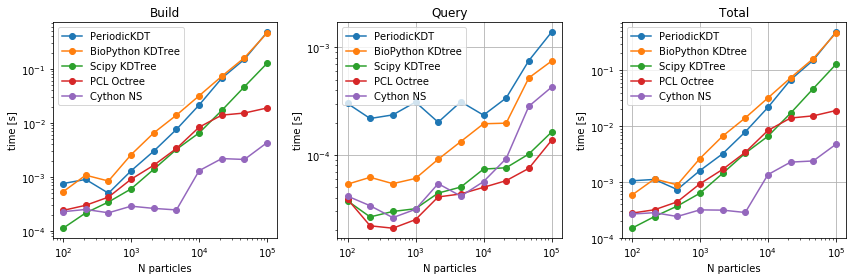

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=plt.figaspect(1/3))

ax = axes[0]
ax.plot(res['N'], res['buildpkd'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['buildbkd'], 'o-', label='BioPython KDTree')
ax.plot(res['N'], res['buildsckd'], 'o-', label='Scipy KDTree')
ax.plot(res['N'], res['buildoct'], 'o-', label='PCL Octree')
ax.plot(res['N'], res['buildns'], 'o-', label='Cython NS')
#ax.plot(res_octree['N'], res_octree['build'], 'o-', label=' Index Based Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[1]
ax.plot(res['N'], res['querypkd'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['querykd'], 'o-', label='BioPython KDtree')
ax.plot(res['N'], res['querysckd'], 'o-', label='Scipy KDTree')
ax.plot(res['N'], res['queryoct'], 'o-', label='PCL Octree')
ax.plot(res['N'], res['queryns'], 'o-', label='Cython NS')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
#ax.plot(res_octree['N'], res_octree['query'], 'o-', label='Index basd Octree')
ax.grid(True)
ax.legend()

ax = axes[2]
ax.plot(res['N'], res['pkd'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['kd'], 'o-', label='BioPython KDtree')
ax.plot(res['N'], res['sckd'], 'o-', label='Scipy KDTree')
ax.plot(res['N'], res['oct'], 'o-', label='PCL Octree')
ax.plot(res['N'], res['ns'], 'o-', label='Cython NS')

ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total')
ax.grid(True)
ax.legend()

fig.tight_layout()

Build Time of Neighbour search implemented in Cython is very fast, which is why the the total time for the method is very low as compared to all others for single queries. However, for multiple queries, non periodic octree should take less time. But it is unknown how it will scale with the implementation of periodic boundary conditions. 

# Lets check the variation with cutoff radius

To see the variation, which is useful for the general use cases in MDAnalysis, lets chose number of particles to be ~40k from above. 

In [16]:
cutoff = np.linspace(2,10,num = 9, dtype = np.float32)

In [30]:
res2 = defaultdict(list)
coords = np.loadtxt('test'+str(NPOINTS[8])+'.txt',dtype = np.float32)
for item in cutoff:
    pkdt = kdtree_build(BOX,coords)
    buildpkdt = %timeit -o -q -n 5 -r 2 kdtree_build(BOX, coords)
    querypkdt = %timeit -o -q -n 5 -r 2 kdtree_query(pkdt, coords, pos, item)
    
    bkdt =  biopython_build(BOX, coords)
    buildbkdt = %timeit -o -q -n 5 -r 2 biopython_build(BOX, coords)
    querybkd = %timeit -o -q -n 5 -r 2 biopython_query(bkdt, coords, pos, item)
    
    sckd = scipy_build(BOX, coords)
    buildsckd = %timeit -o -q -n 5 -r 2 scipy_build(BOX, coords)
    querysckd = %timeit -o -q -n 5 -r 2 scipy_query(sckd, coords, pos, item)
    
    octree = octree_build(BOX, coords)
    buildoct = %timeit -q -o -n 5 -r 2 octree_build(BOX, coords)
    queryoct = %timeit -o -q octree_query(octree, coords, pos, item)
    
    ns = ns_build(BOX, coords, CUTOFF)
    buildns = %timeit -o -q -n 5 -r 2 ns_build(BOX, coords, CUTOFF)
    queryns = %timeit -o -q  -n 5 -r 2 ns_query(ns, coords, pos)
    
    res2['pkd'].append(querypkdt.average + buildpkdt.average)
    res2['bkd'].append(querybkd.average + buildbkdt.average)
    res2['sckd'].append(querysckd.average + buildsckd.average)
    res2['oct'].append(queryoct.average + buildoct.average)
    res2['ns'].append(queryns.average + buildns.average)
    res2['cutoff'].append(item)

In [91]:
res_octree = defaultdict(list)
res_octree['query'] = [ 0.000065300 , 0.000057000, 0.000060200, 0.000063000,
                       0.000057400, 0.000090000, 0.000191700, 0.000117500, 0.000126000]
res_octree['cutoff'] = res2['cutoff']

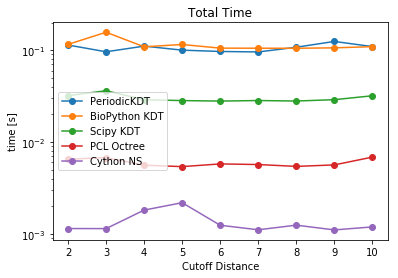

In [32]:
fig, ax = plt.subplots()
ax.plot(res2['cutoff'], res2['pkd'], 'o-', label='PeriodicKDT')
ax.plot(res2['cutoff'], res2['bkd'], 'o-', label='BioPython KDT')
ax.plot(res2['cutoff'], res2['sckd'], 'o-', label='Scipy KDT')
ax.plot(res2['cutoff'], res2['oct'], 'o-', label='PCL Octree')
ax.plot(res2['cutoff'], res2['ns'], 'o-', label='Cython NS')
#ax.plot(res_octree['cutoff'], res_octree['query'], 'o-', label='Index Based Octree')
ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Total Time')
ax.legend()

For a single query, Neighbour search is definintely the best method so far. However, it needs to be checked for multiple queries such as pair contacts, distance search etc. One advantage of tree structure is they are constructed only once and can check multiple cutoff radius from multiple query points whereas, Neighbour search implementation needs to be initialized everytime the cutoff radius is modified. 